In [405]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

os.chdir('/home/tm_ba/Desktop/Bachelorarbeit_code')
print(os.get_exec_path())

['/home/tm_ba/miniconda3/envs/BA/bin', '/home/tm_ba/miniconda3/condabin', '/opt/ros/noetic/bin', '/usr/local/sbin', '/usr/local/bin', '/usr/sbin', '/usr/bin', '/sbin', '/bin', '/usr/games', '/usr/local/games', '/snap/bin']


In [406]:
import pandas as pd
import os

def parse_and_merge_tables(file_paths):
    """
    Parses the tables from the given list of files and merges tables of the same kind.

    Args:
        file_paths (list): List of paths to the files containing the tables.

    Returns:
        dict: A dictionary where the keys are table names, and the values are merged DataFrames.
    """
    # Initialize a dictionary to store DataFrames with table names as keys
    merged_tables = {}
    to_delete = []

    for recording_idx, file_path in enumerate(file_paths):
        with open(file_path, 'r') as file:
            # Read the entire content of the file
            content = file.read()

        # Split the content by double newlines to separate the tables
        tables = content.strip().split('\n\n')

        for table in tables:
            # Split the table content by lines
            lines = table.strip().split('\n')

            # Extract the table name from the first line
            table_name = lines[0].strip()

            # Extract the Hz information (metadata) from the second line
            hz = lines[1].strip()

            # Parse the column headers and units from the next three lines
            group_headers = lines[2].split(',')  # Group headers (first row)
            column_headers = lines[3].split(',')  # Column names (second row)
            units = lines[4].split(',')  # Units (third row)

            # Create a list to hold the full column names
            columns = []
            current_group = ""

            # Construct the full column names using group headers, column names, and units
            for group_header, column_header, unit in zip(group_headers, column_headers, units):
                if group_header.strip():  # Update the current group if it's not empty
                    current_group = group_header.strip()
                full_column_name = ""
                if current_group:
                    full_column_name += f"{current_group}:"
                full_column_name += f"{column_header.strip()}"
                if unit.strip():
                    full_column_name += f" ({unit.strip()})"
                columns.append(full_column_name)

            # Parse the data rows starting from the 6th line onward
            data = [line.split(',') for line in lines[5:]]

            # Create a DataFrame for the current table
            df = pd.DataFrame(data, columns=columns)

            # Convert numeric columns to appropriate types where possible
            df = df.apply(pd.to_numeric, errors='ignore')

            # Attach metadata (Hz information) to the DataFrame as an attribute
            df.attrs['hz'] = hz

            # Check for duplicate column names and handle them by renaming
            if len(df.columns) != len(set(df.columns)):
                # Automatically renames duplicate columns
                df.columns = pd.io.parsers.ParserBase({'names': df.columns})._maybe_dedup_names(df.columns)
                to_delete.append(file_path)

            # Add 'Recording' column to track the file source
            df['Recording'] = recording_idx

            
            df.drop(columns=[col for col in df.columns if "Triangle1" in col], inplace=True)

            # If the table has already been seen, merge the new data into the existing DataFrame
            if table_name in merged_tables:
                existing_df = merged_tables[table_name]

                # Align columns before concatenation
                merged_tables[table_name] = pd.concat([existing_df, df], ignore_index=True)
            else:
                merged_tables[table_name] = df

    # Optionally, remove files with duplicate column names
    for csv in to_delete:
        os.remove(csv)

    return merged_tables


In [407]:
data_directory  = "Mathew" 
data_paths = [os.path.join(data_directory, data_path) for data_path in os.listdir(data_directory)]
tables_dict = parse_and_merge_tables(data_paths)


/tmp/ipykernel_149772/1550505253.py:64: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/tmp/ipykernel_149772/1550505253.py:64: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/tmp/ipykernel_149772/1550505253.py:64: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/tmp/ipykernel_149772/1550505253.py:64: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/tmp

In [408]:
# Display the tables in the dictionary
for table_name, df in tables_dict.items():
    print(f"Table Name: {table_name}")
    print(f"Hz: {df.attrs['hz']}")
    print(f"Columns: {df.columns}")
    os.makedirs('csv_new', exist_ok=True)
    df.to_csv(f"csv_new/{table_name}.csv", index=False)  # Save the DataFrame to a CSV file
    print("\n" + "-"*50 + "\n")  # Separator between tables

Table Name: Joints
Hz: 200
Columns: Index(['Frame', 'Sub Frame', 'Mathew:HandOuter_Thumb:RX (deg)',
       'Mathew:HandOuter_Thumb:RY (deg)', 'Mathew:HandOuter_Thumb:RZ (deg)',
       'Mathew:LowerArm_HandOuter:RX (deg)',
       'Mathew:LowerArm_HandOuter:RY (deg)',
       'Mathew:LowerArm_HandOuter:RZ (deg)',
       'Mathew:UpperArm_LowerArm:RX (deg)',
       'Mathew:UpperArm_LowerArm:RY (deg)',
       'Mathew:UpperArm_LowerArm:RZ (deg)', 'Mathew:World_UpperArm:RX (deg)',
       'Mathew:World_UpperArm:RY (deg)', 'Mathew:World_UpperArm:RZ (deg)',
       'Mathew:World_UpperArm:TX (mm)', 'Mathew:World_UpperArm:TY (mm)',
       'Mathew:World_UpperArm:TZ (mm)', 'Recording'],
      dtype='object')

--------------------------------------------------

Table Name: Segments
Hz: 200
Columns: Index(['Frame', 'Sub Frame', 'Mathew:HandOuter:RX (deg)',
       'Mathew:HandOuter:RY (deg)', 'Mathew:HandOuter:RZ (deg)',
       'Mathew:HandOuter:TX (mm)', 'Mathew:HandOuter:TY (mm)',
       'Mathew:HandOu

In [409]:
trajectories = tables_dict["Trajectories"]
trajectories

,Frame,Sub Frame,Mathew:shoulder:X (mm),Mathew:shoulder:Y (mm),Mathew:shoulder:Z (mm),Mathew:shoulderElbowSupport:X (mm),Mathew:shoulderElbowSupport:Y (mm),Mathew:shoulderElbowSupport:Z (mm),Mathew:elbow:X (mm),Mathew:elbow:Y (mm),...,Mathew:elbowWrist:X (mm),Mathew:elbowWrist:Y (mm),Mathew:elbowWrist:Z (mm),Mathew:Triangle2:X (mm),Mathew:Triangle2:Y (mm),Mathew:Triangle2:Z (mm),Mathew:ThumbTip:X (mm),Mathew:ThumbTip:Y (mm),Mathew:ThumbTip:Z (mm),Recording
0,1,0,424.573,31.46390,632.820,468.277,46.7705,443.600,437.244,95.0522,...,396.319,145.3050,191.947,246.222,197.514,74.8402,208.065,226.836,58.5300,0
1,2,0,424.260,31.44500,632.718,467.946,47.3265,443.768,436.375,95.5444,...,394.630,146.4070,192.751,244.034,197.688,75.1489,205.831,226.619,58.8733,0
2,3,0,424.073,31.44570,632.837,467.521,47.7943,443.758,435.643,96.2625,...,393.247,147.4150,193.529,241.699,197.913,76.6041,203.393,225.856,59.2708,0
3,4,0,423.898,31.59660,632.891,467.049,48.2684,443.627,434.516,96.9949,...,391.708,148.0680,194.022,239.639,198.164,78.2239,200.365,225.176,59.9573,0
4,5,0,423.604,31.65990,632.974,466.561,48.8856,443.475,433.747,97.6751,...,390.033,149.0990,194.498,237.279,198.358,78.9482,197.646,224.697,60.5265,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29035,484,0,472.782,-7.33897,652.253,535.728,-16.3590,461.963,554.699,35.5385,...,581.487,93.6361,215.385,552.405,245.451,78.3614,553.403,289.602,36.5813,50
29036,485,0,472.814,-7.35831,652.198,535.742,-16.4615,461.932,554.922,35.4013,...,581.569,93.5538,215.329,552.566,245.691,78.9424,553.230,289.540,36.6210,50
29037,486,0,472.883,-7.35738,652.159,535.819,-16.5510,461.839,555.211,35.2621,...,581.622,93.4419,215.321,552.636,245.788,79.3251,553.066,289.457,36.4266,50
29038,487,0,472.944,-7.36919,652.078,535.896,-16.7327,461.831,555.527,35.0052,...,581.873,93.4184,215.278,552.639,245.982,79.6639,552.995,289.511,36.4619,50


In [410]:
trajectories["Recording"].value_counts()

Recording
18    994
14    805
28    767
31    762
48    758
37    666
2     663
9     661
25    651
11    640
6     638
7     635
44    634
33    632
38    632
1     612
39    612
34    611
26    605
5     602
36    585
46    583
47    582
21    575
35    565
43    560
41    558
15    548
27    545
32    545
13    544
24    534
22    526
8     523
3     522
49    494
50    488
0     475
12    474
29    471
42    464
19    457
30    452
17    447
4     446
10    437
20    435
16    434
40    403
23    398
45    390
Name: count, dtype: int64

In [411]:
df["Recording"].value_counts()

Recording
18    994
14    805
28    767
31    762
48    758
37    666
2     663
9     661
25    651
11    640
6     638
7     635
44    634
33    632
38    632
1     612
39    612
34    611
26    605
5     602
36    585
46    583
47    582
21    575
35    565
43    560
41    558
15    548
27    545
32    545
13    544
24    534
22    526
8     523
3     522
49    494
50    488
0     475
12    474
29    471
42    464
19    457
30    452
17    447
4     446
10    437
20    435
16    434
40    403
23    398
45    390
Name: count, dtype: int64

In [412]:
num_landmarks = (trajectories.shape[1] - 2) // 3 

In [413]:
speeds = []
for i in range(1, trajectories.shape[0]):
    speed_frame = []
    for j in range(2, num_landmarks * 3 + 2, 3):
        dx = trajectories.iloc[i, j] - trajectories.iloc[i-1, j]
        dy = trajectories.iloc[i, j + 1] - trajectories.iloc[i-1, j + 1]
        dz = trajectories.iloc[i, j + 2] - trajectories.iloc[i-1, j + 2]
        speed = np.sqrt(dx**2 + dy**2 + dz**2)
        speed_frame.append(speed)
    speed_frame.append(trajectories.iloc[i]["Recording"])
    speeds.append(speed_frame)

speeds_df = pd.DataFrame(speeds, columns=[f'{trajectories.columns[2 + i*3].split(":")[1]}' for i in range(num_landmarks)] + ["Recording"])
speeds_df.to_csv('./csv_new/Speeds.csv', index=False)

In [414]:
speeds_df["Recording"].value_counts()

Recording
18.0    994
14.0    805
28.0    767
31.0    762
48.0    758
37.0    666
2.0     663
9.0     661
25.0    651
11.0    640
6.0     638
7.0     635
44.0    634
33.0    632
38.0    632
1.0     612
39.0    612
34.0    611
26.0    605
5.0     602
36.0    585
46.0    583
47.0    582
21.0    575
35.0    565
43.0    560
41.0    558
15.0    548
27.0    545
32.0    545
13.0    544
24.0    534
22.0    526
8.0     523
3.0     522
49.0    494
50.0    488
12.0    474
0.0     474
29.0    471
42.0    464
19.0    457
30.0    452
17.0    447
4.0     446
10.0    437
20.0    435
16.0    434
40.0    403
23.0    398
45.0    390
Name: count, dtype: int64

In [415]:
recording_idx = 23
visualized_speeds_df = speeds_df[speeds_df["Recording"] == recording_idx].drop("Recording", axis=1)
visualized_speeds_df

,shoulder,shoulderElbowSupport,elbow,wrist,elbowWrist,Triangle2,ThumbTip
13092,58.247931,98.858881,139.068257,NaN,197.914242,NaN,354.728893
13093,0.511703,0.810576,1.347442,NaN,2.338473,NaN,5.029347
13094,0.466587,0.937710,1.433640,NaN,2.022800,NaN,4.236017
13095,0.469251,1.036871,1.631153,NaN,2.558219,NaN,4.405586
13096,0.431917,0.929297,1.609261,NaN,1.964402,NaN,4.592964
...,...,...,...,...,...,...,...
13485,0.084319,0.034296,0.113262,0.052498,0.005196,NaN,0.315566
13486,0.088690,0.161333,0.091109,0.367279,0.035398,NaN,0.099324
13487,0.065575,0.115214,0.058056,0.119587,0.058086,NaN,0.051385
13488,0.030676,0.017396,0.063530,0.038962,0.062690,NaN,0.148514


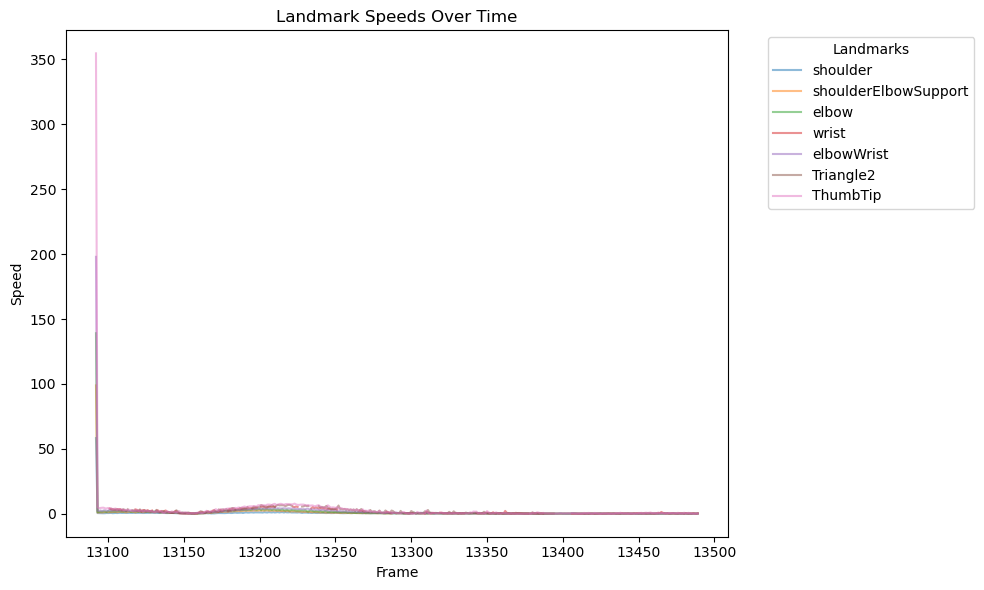

In [416]:
plt.figure(figsize=(10, 6))
for column in visualized_speeds_df.columns:
    plt.plot(visualized_speeds_df.index, visualized_speeds_df[column], label=column, alpha=0.5)

plt.title('Landmark Speeds Over Time')
plt.xlabel('Frame')
plt.ylabel('Speed')
plt.legend(title='Landmarks', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [417]:
# Schritt 1: Berechnen des IQR und Ausreißer-Grenzen festlegen
Q1 = speeds_df.quantile(0.25)
Q3 = speeds_df.quantile(0.75)
IQR = Q3 - Q1

# Festlegung der Grenzen, um Ausreißer zu entfernen (1.5-facher IQR)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Schritt 2: Entfernen der Ausreißer
filtered_speeds_df = speeds_df[~((speeds_df < lower_bound) | (speeds_df > upper_bound)).any(axis=1)]


In [418]:
def moving_average(data, window_size):
    return data.rolling(window=window_size, min_periods=1, center=True).mean()

# Apply the moving average to each column in the DataFrame
window_size = 10  # Adjust the window size as needed
smoothed_speeds_df = filtered_speeds_df.apply(moving_average, window_size=window_size)

In [419]:
visualized_speeds_df = smoothed_speeds_df[smoothed_speeds_df["Recording"] == recording_idx].drop("Recording", axis=1)
visualized_speeds_df

,shoulder,shoulderElbowSupport,elbow,wrist,elbowWrist,Triangle2,ThumbTip
13098,0.494992,1.062327,1.641301,3.500339,2.380964,3.753786,4.373920
13099,0.485796,1.110703,1.686389,3.497898,2.377791,3.457662,4.223542
13100,0.487231,1.151506,1.714483,3.374696,2.434987,3.396823,4.172102
13101,0.499489,1.184203,1.725451,3.306738,2.432500,3.369271,4.129416
13102,0.506883,1.205998,1.762679,3.275239,2.459036,3.409178,3.981272
...,...,...,...,...,...,...,...
13481,0.090340,0.074542,0.098647,0.220559,0.052738,NaN,0.424141
13482,0.086303,0.080271,0.095045,0.235992,0.048267,NaN,0.363122
13483,0.084550,0.088283,0.089743,0.213576,0.045248,NaN,0.339922
13484,0.078054,0.080643,0.081228,0.187713,0.048361,NaN,0.312949


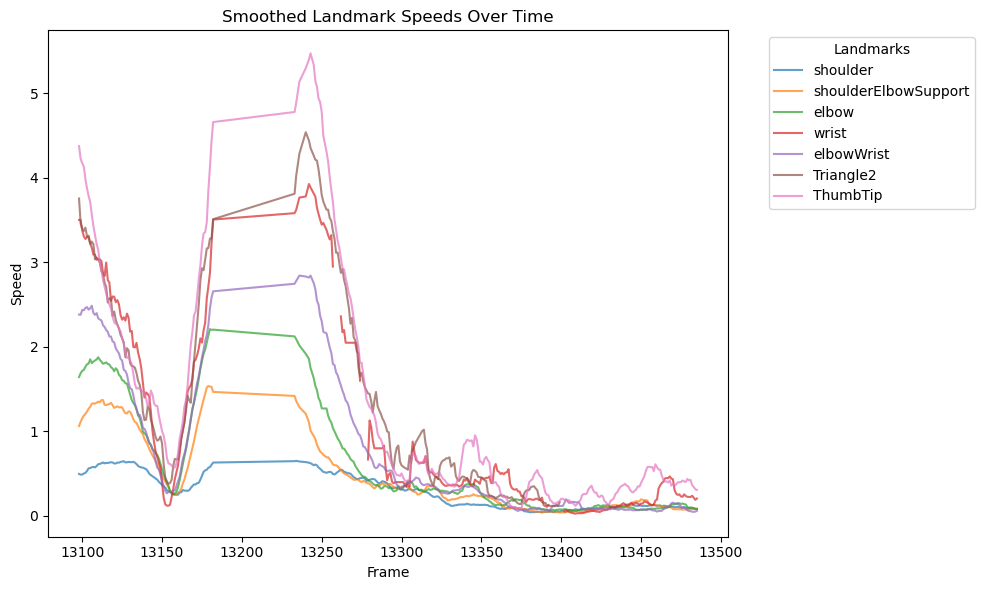

In [420]:
# Plotting smoothed speeds with transparency
plt.figure(figsize=(10, 6))
for column in visualized_speeds_df.columns:
    plt.plot(visualized_speeds_df.index, visualized_speeds_df[column], label=column, alpha=0.7)  # Adjust alpha for transparency

plt.title('Smoothed Landmark Speeds Over Time')
plt.xlabel('Frame')
plt.ylabel('Speed')
plt.legend(title='Landmarks', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [421]:
trajectories.isna().sum().sum()

35193

In [467]:
pd.read_csv('csv_new/Trajectories.csv').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29040 entries, 0 to 29039
Data columns (total 24 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Frame                               29040 non-null  int64  
 1   Sub Frame                           29040 non-null  int64  
 2   Mathew:shoulder:X (mm)              29040 non-null  float64
 3   Mathew:shoulder:Y (mm)              29040 non-null  float64
 4   Mathew:shoulder:Z (mm)              29040 non-null  float64
 5   Mathew:shoulderElbowSupport:X (mm)  29040 non-null  float64
 6   Mathew:shoulderElbowSupport:Y (mm)  29040 non-null  float64
 7   Mathew:shoulderElbowSupport:Z (mm)  29040 non-null  float64
 8   Mathew:elbow:X (mm)                 28855 non-null  float64
 9   Mathew:elbow:Y (mm)                 28855 non-null  float64
 10  Mathew:elbow:Z (mm)                 28855 non-null  float64
 11  Mathew:wrist:X (mm)                 21929

In [498]:
import pandas as pd
import numpy as np

def read_and_process_data(file_path):
    # Load data
    data = pd.read_csv(file_path)

    # Preserve the 'Sequence' column (do not include it in the outlier processing)
    sequence_col = data['Recording']
    
    # Calculate differences between consecutive frames for all columns except 'Frame' and 'Sub Frame'
    position_columns = [col for col in data.columns if col not in ['Frame', 'Sub Frame', 'Recording']]  # Exclude 'Sequence'
    differences = data[position_columns].diff().abs()

    # Identify outliers using the IQR method
    Q1 = differences.quantile(0.25)
    Q3 = differences.quantile(0.75)
    IQR = Q3 - Q1
    outlier_threshold = Q3 + 1.5 * IQR

    # Create a mask for outliers
    outliers = (differences > outlier_threshold)

    # Interpolate outliers and handle NaNs
    for col in position_columns:
        # Mark outliers as NaN
        data.loc[outliers[col], col] = np.nan
        
        # Remove only the outliers at the beginning of the dataset (consecutive NaNs at the start)

        # Interpolate NaN values (including consecutive NaNs) using linear interpolation
        data[col] = data[col].interpolate(method='linear', limit_direction='both')
        
        # Optional: Fill any remaining NaNs at the start or end of the series using forward and backward fill
        data[col] = data[col].ffill().bfill()

    # Restore the 'Sequence' column after processing
    data['Recording'] = sequence_col.iloc[data.index].reset_index(drop=True)

    return data

# Usage
processed_data = read_and_process_data('csv_new/Trajectories.csv')
processed_data.to_csv('csv_new/processed_Trajectories.csv', index=False)


In [499]:
processed_data.value_counts("Recording")

Recording
18    994
14    805
28    767
31    762
48    758
37    666
2     663
9     661
25    651
11    640
6     638
7     635
44    634
33    632
38    632
1     612
39    612
34    611
26    605
5     602
36    585
46    583
47    582
21    575
35    565
43    560
41    558
15    548
27    545
32    545
13    544
24    534
22    526
8     523
3     522
49    494
50    488
0     475
12    474
29    471
42    464
19    457
30    452
17    447
4     446
10    437
20    435
16    434
40    403
23    398
45    390
Name: count, dtype: int64

In [500]:
speeds = []
for i in range(1, processed_data.shape[0]):
    speed_frame = []
    for j in range(2, num_landmarks * 3 + 2, 3):
        dx = processed_data.iloc[i, j] - processed_data.iloc[i-1, j]
        dy = processed_data.iloc[i, j + 1] - processed_data.iloc[i-1, j + 1]
        dz = processed_data.iloc[i, j + 2] - processed_data.iloc[i-1, j + 2]
        speed = np.sqrt(dx**2 + dy**2 + dz**2)
        speed_frame.append(speed)
    speed_frame.append(processed_data.iloc[i]["Recording"])
    speeds.append(speed_frame)

processed_speeds_df = pd.DataFrame(speeds, columns=[f'{processed_data.columns[2 + i*3].split(":")[1]}' for i in range(num_landmarks)] + ["Recording"])


In [501]:
visualized_speeds_df = processed_speeds_df.drop("Recording", axis=1)
visualized_speeds_df

,shoulder,shoulderElbowSupport,elbow,wrist,elbowWrist,Triangle2,ThumbTip
0,0.329743,0.668522,1.072887,2.710070,2.147594,2.216510,2.270617
1,0.221654,0.632109,1.025659,2.881245,1.905518,2.760518,2.585347
2,0.237301,0.681701,1.344138,2.881245,1.742980,2.632556,3.178438
3,0.311981,0.801364,1.129129,2.881245,2.023651,2.476257,2.818934
4,0.284974,0.698891,1.194251,2.881245,1.934976,2.449845,2.772345
...,...,...,...,...,...,...,...
29034,0.192630,0.132883,0.153549,0.384861,0.122456,0.325042,1.011950
29035,0.066506,0.107997,0.315482,0.128300,0.128970,0.648908,0.188014
29036,0.079265,0.150294,0.357137,0.083570,0.124075,0.400959,0.267538
29037,0.102086,0.197504,0.451098,0.000000,0.255739,0.390423,0.095933


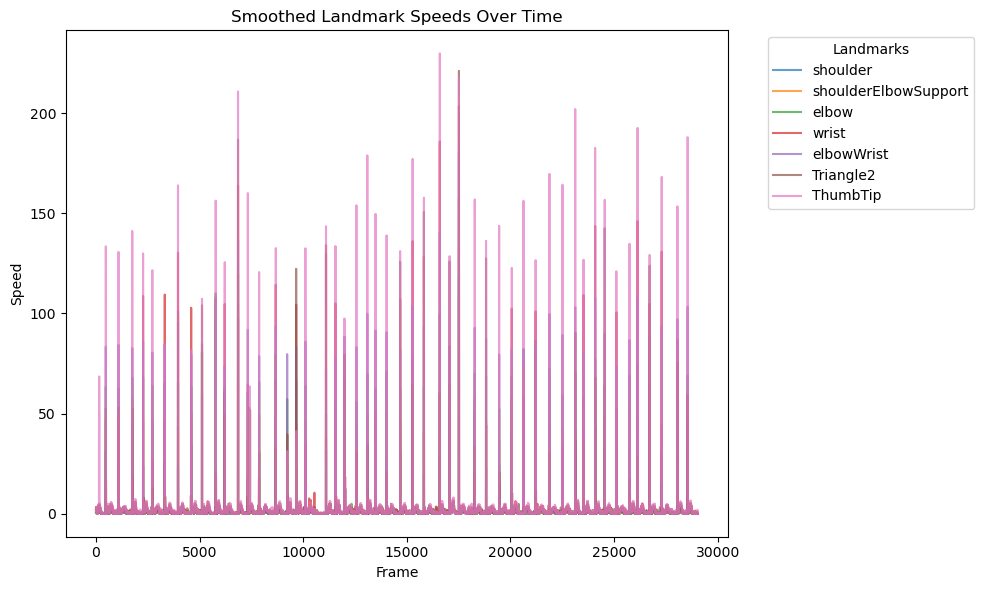

In [502]:
# Plotting smoothed speeds with transparency
plt.figure(figsize=(10, 6))
for column in visualized_speeds_df.columns:
    plt.plot(visualized_speeds_df.index, visualized_speeds_df[column], label=column, alpha=0.7)  # Adjust alpha for transparency

plt.title('Smoothed Landmark Speeds Over Time')
plt.xlabel('Frame')
plt.ylabel('Speed')
plt.legend(title='Landmarks', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [465]:
!jupyter nbconvert --to script Code/preprocessing/read_data.ipynb


[NbConvertApp] Converting notebook Code/preprocessing/read_data.ipynb to script
[NbConvertApp] Writing 10692 bytes to Code/preprocessing/read_data.py


In [466]:
processed_data.rename(columns={"Recording": "Sequence"}).drop(columns=["Sub Frame"]).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29040 entries, 0 to 29039
Data columns (total 23 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Frame                               29040 non-null  int64  
 1   Mathew:shoulder:X (mm)              29040 non-null  float64
 2   Mathew:shoulder:Y (mm)              29040 non-null  float64
 3   Mathew:shoulder:Z (mm)              29040 non-null  float64
 4   Mathew:shoulderElbowSupport:X (mm)  29040 non-null  float64
 5   Mathew:shoulderElbowSupport:Y (mm)  29040 non-null  float64
 6   Mathew:shoulderElbowSupport:Z (mm)  29040 non-null  float64
 7   Mathew:elbow:X (mm)                 29040 non-null  float64
 8   Mathew:elbow:Y (mm)                 29040 non-null  float64
 9   Mathew:elbow:Z (mm)                 29040 non-null  float64
 10  Mathew:wrist:X (mm)                 29040 non-null  float64
 11  Mathew:wrist:Y (mm)                 29040